In [ ]:
from google import colab

colab.drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Preprocessing and Initial Model Training Attempt

In [ ]:
!unzip /content/gdrive/MyDrive/archive.zip -d /content

In [ ]:
import numpy as np
import dlib
import cv2
import glob
from PIL import Image
import os
import warnings

warnings.filterwarnings('ignore')

def format_image(image):
  if len(image.shape) > 2 and image.shape[2] == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    image = cv2.imdecode(image, cv2.CV_LOAD_IMAGE_GRAYSCALE)
  detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
  rects = detector(image, 1)

  w_max = 0
  h_max = 0

  found_face = False
  for faceRect in rects:
    rect = faceRect.rect
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    if (w*h)>(w_max*h_max):
      w_max=w
      h_max=h
      found_face = True
      img_crop = image[abs(rect.top()):abs(rect.bottom()), abs(rect.left()):abs(rect.right())]

  if found_face:
      img_crop = Image.fromarray(np.uint8(img_crop))
      resized_crop = img_crop.resize((256, 256), Image.ANTIALIAS)
      data_crop = np.asarray(resized_crop, dtype="uint8").reshape([256,256])
  else:
      return None

  data_crop = data_crop - np.mean(data_crop)
  f_b = np.sqrt(np.sum(np.square(data_crop)))

  if f_b==0:
    return None

  data_crop = data_crop * (100 / f_b)

  return data_crop


def save_data(X_train, y_train, fname='', folder='/content/preprocessed_data/'):
    if not os.path.exists(folder):
        os.makedirs(folder)
        np.save(folder + 'X_' + fname, X_train)
        np.save(folder + 'y_' + fname, y_train)
    else:
        X_train.append(np.load(folder + 'X_' + fname))
        y_train.append(np.load(folder + 'y_' + fname))
        np.save(folder + 'X_' + fname, X_train)
        np.save(folder + 'y_' + fname, y_train)


def convert_csv_to_img(path):

    with open(path) as f:
        content = f.readlines()

    lines = np.array(content)

    num_of_instances = lines.size

    for i in range(1, num_of_instances):
        try:
            emotion, img, split = lines[i].split(",")
            img = img.replace('"', '')
            img = img.replace('\n', '')
            pixels = img.split(" ")

            pixels = np.array(pixels, 'float32')
            image = pixels.reshape(256, 256)

            path_file_name = str(i)+"_example.jpg"
            cv2.imwrite(path_file_name, image)

        except Exception as ex:
            print(ex)

if __name__ == "__main__":

    print(">>>preprocessing...<<<")

    cv_img = []
    cv_label = []
    labels = {}
    for i, label in enumerate(os.listdir("/content/Student-engagement-dataset/Engaged")):
      for img in glob.glob(f"/content/Student-engagement-dataset/Engaged/{label}/*.jpg"):
          input = cv2.imread(img)
          detected_input = format_image(input)
          if detected_input is None:
              continue
          cv_img.append(detected_input)
          cv_label.append(i)
      labels[i] = label
    for i, label in enumerate(os.listdir("/content/Student-engagement-dataset/Not engaged")):
      for img in glob.glob(f"/content/Student-engagement-dataset/Not engaged/{label}/*.jpg"):
          input = cv2.imread(img)
          detected_input = format_image(input)
          if detected_input is None:
              continue
          cv_img.append(detected_input)
          cv_label.append(i+3)
      labels[i+3] = label
    save_data(cv_img, cv_label, 'train')
    print(">>>preprocessing done<<<")
    print(">>>data saved at /content/preprocessed_data<<<")

In [ ]:
def save_data_drive(X_train, y_train, fname='', folder='/content/gdrive/MyDrive/preprocessed_data/'):
    if not os.path.exists(folder):
        os.makedirs(folder)
        np.save(folder + 'X_' + fname, X_train)
        np.save(folder + 'y_' + fname, y_train)
    else:
        X_train.append(np.load(folder + 'X_' + fname))
        y_train.append(np.load(folder + 'y_' + fname))
        np.save(folder + 'X_' + fname, X_train)
        np.save(folder + 'y_' + fname, y_train)
save_data_drive(cv_img, cv_label, 'train')

In [ ]:
print(f">>>Shape of X_train: {np.load('/content/preprocessed_data/X_train.npy').shape}<<<")
print(f">>>Shape of y_train: {np.load('/content/preprocessed_data/y_train.npy').shape}<<<")

>>>Shape of X_train: (2082, 256, 256)<<<
>>>Shape of y_train: (2082,)<<<


In [ ]:
X = np.load('/content/preprocessed_data/X_train.npy')
X.shape

(2082, 256, 256)

In [ ]:
X[0].shape

(256, 256)

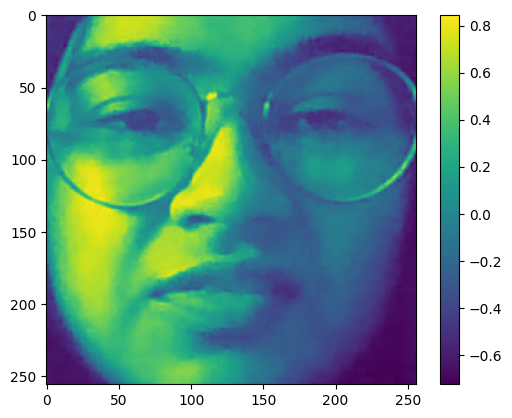

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def matrix_to_image(matrix, cmap='viridis', save_path=None):
    plt.imshow(matrix, cmap=cmap)
    plt.colorbar()

    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

image = X[0]
matrix_to_image(image, cmap='viridis')


In [ ]:
y = np.load('/content/preprocessed_data/y_train.npy')
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [ ]:
y = np.where(y > 2, y-3, y)

In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [ ]:
X[0][1]

array([-0.42449816, -0.44406331, -0.45710675, -0.46362847, -0.47667191,
       -0.48319362, -0.50275878, -0.51580222, -0.52884566, -0.53536737,
       -0.53536737, -0.52884566, -0.5092805 , -0.5092805 , -0.48971534,
       -0.47015019, -0.46362847, -0.45710675, -0.45710675, -0.45710675,
       -0.49623706, -0.49623706, -0.48971534, -0.47667191, -0.45710675,
       -0.41145472, -0.35275925, -0.29406378, -0.26145519, -0.13102081,
        0.01897872,  0.11680451,  0.21463029,  0.27984748,  0.28636919,
        0.31245607,  0.39723841,  0.4950642 ,  0.52115107,  0.52767279,
        0.54723795,  0.5994117 ,  0.63854201,  0.64506373,  0.65158545,
        0.67767232,  0.67767232,  0.68419404,  0.69071576,  0.69723748,
        0.7037592 ,  0.71028092,  0.71680263,  0.71680263,  0.71680263,
        0.71680263,  0.71028092,  0.71028092,  0.7037592 ,  0.7037592 ,
        0.7037592 ,  0.7037592 ,  0.71028092,  0.71028092,  0.71680263,
        0.72332435,  0.72984607,  0.72984607,  0.73636779,  0.73

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y=to_categorical(y, num_classes=6)
np.unique(y)

array([0., 1.], dtype=float32)

In [ ]:
y

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
labels

{0: 'frustrated',
 1: 'engaged',
 2: 'confused',
 3: 'Looking Away',
 4: 'drowsy',
 5: 'bored'}

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
train_images.shape

(1665, 256, 256)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

model = models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
train_images = np.stack((train_images,)*3, axis=-1)
test_images = np.stack((test_images,)*3, axis=-1)

train_images.shape

(1665, 256, 256, 3)

In [ ]:
model.fit(
    datagen.flow(train_images, train_labels, batch_size=8),
    epochs=100,
)

Epoch 1/100
209/209 [==============================] - 81s 216ms/step - loss: 1.5269 - accuracy: 0.4072 - val_loss: 19.4585 - val_accuracy: 0.1703
Epoch 2/100
209/209 [==============================] - 36s 174ms/step - loss: 1.2268 - accuracy: 0.4685 - val_loss: 1.8021 - val_accuracy: 0.1703
Epoch 3/100
209/209 [==============================] - 37s 178ms/step - loss: 0.9936 - accuracy: 0.5327 - val_loss: 1.5548 - val_accuracy: 0.2422
Epoch 4/100
209/209 [==============================] - 36s 174ms/step - loss: 1.2857 - accuracy: 0.4216 - val_loss: 3.2313 - val_accuracy: 0.0072
Epoch 5/100
209/209 [==============================] - 37s 176ms/step - loss: 1.1610 - accuracy: 0.4697 - val_loss: 1.7152 - val_accuracy: 0.4005
Epoch 6/100
209/209 [==============================] - 36s 170ms/step - loss: 1.0208 - accuracy: 0.5147 - val_loss: 1.5882 - val_accuracy: 0.4101
Epoch 7/100
209/209 [==============================] - 38s 180ms/step - loss: 0.9252 - accuracy: 0.5652 - val_loss: 0.8345 

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_images, test_labels)

# Evaluation and Experimental Results of Trained Model (Continuation after Model Creation Notebook)

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/MyDrive/engageplus.h5')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 23718978 (90.48 MB)
Trainable params: 23665858 (90.28 MB)
Non-trainable params: 53120 (207.50 KB)
________

In [ ]:
from PIL import Image
import dlib
import cv2

def format_image(image):
  if len(image.shape) > 2 and image.shape[2] == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    image = cv2.imdecode(image, cv2.CV_LOAD_IMAGE_GRAYSCALE)
  detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
  rects = detector(image, 1)

  w_max = 0
  h_max = 0

  found_face = False
  for faceRect in rects:
    rect = faceRect.rect
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    if (w*h)>(w_max*h_max):
      w_max=w
      h_max=h
      found_face = True
      img_crop = image[abs(rect.top()):abs(rect.bottom()), abs(rect.left()):abs(rect.right())]

  if found_face:
      img_crop = Image.fromarray(np.uint8(img_crop))
      resized_crop = img_crop.resize((256, 256), Image.ANTIALIAS)
      data_crop = np.asarray(resized_crop, dtype="uint8").reshape([256,256])
  else:
      return None

  data_crop = data_crop - np.mean(data_crop)
  f_b = np.sqrt(np.sum(np.square(data_crop)))

  if f_b==0:
    return None

  data_crop = data_crop * (100 / f_b)

  return data_crop

In [ ]:
import cv2
import numpy as np

d = {3: 'Drowsy', 2: 'Frustrated', 1: 'Confused', 0: 'Engaged', 4: 'Bored', 5: 'Looking Away'}
d = {0: 'Engaged', 1: 'Not Engaged'}

img = cv2.imread('idk.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (256, 256))
# img = img/255.0

img = format_image(img)
img = np.stack((img,)*3, axis=-1)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
print(pred)
pred = np.argmax(pred)
pred_class = d[pred]
pred_class

1/1 [==============================] - 0s 35ms/step
[[5.869102e-10 1.000000e+00]]


<ipython-input-58-836aed67ea1c>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_crop = img_crop.resize((256, 256), Image.ANTIALIAS)


'Not Engaged'

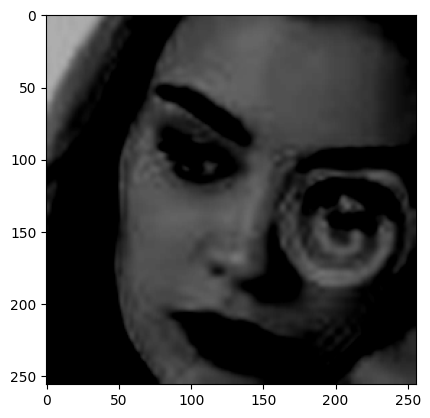

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img[0])